# LightGBM
일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할(Leaf Wise) 방식을 사용  
리프 중심 트리 분할: 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성  
이렇게 최대 손실 값을 가지는 리프 노드를 지속적으로 분할해 생성된 규칙 트리는 학습을 반복할수록 결국 균형 트리 분할 방식보다 예측 오류 손실을 최소화 할 수 있음 

## LightGBM 장점
더 빠른 학습과 예측 수행 시간  
더 작은 메모리 사용량  
카테고리형 피처의 자동 변환과 최적 분할

## LightGBM 하이퍼 파라미터
XGBoost와 유사하나 특성에 맞는 하이퍼 파라미터 설정 필요  
num_iterations(n_estimators, default = 100) : 반복 수행하려는 트리의 개수, 크게 설정할수록 예측 성능이 높아질 수 있으나 너무 크면 과적합  
learning_rate(default = 0.01) : 학습률 값, 작게 해서 예측 성능 향상 가능하나 과적합 이슈 고려  
max_depth(default = 1) : 트리 기반 알고리즘의 max_depth, 리프 중심 트리 분할 방식이므로 깊이가 상대적으로 더 깊다  
min_data_in_leaf(min_child_samples, default = 20) : min_sample_leaf와 같은 파라미터, 최종 결정 클래스인 리프 노드가 되기 위해 최소한으로 필요한 레코드 수  
num_leaves(default = 31) : 하나의 트리가 가질 수 있는 최대 리프 개수  
boosting(default = gbdt) : 부스팅의 트리를 생성하는 알고리즘 gbdt: 일반적인 그래디언트 부스팅 결정트리, rf: 랜덤 포레스트  
bagging_fraction(subsample, default = 1.0) : 트리가 커져 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율 지정  
feature_fraction(colsample_bytree, default = 1.0) : 개별 트리를 학습 할 대마다 무작위로 선택하는 피처의 비율  
lambda_l2(reg_lambda, default = 0.0) : L2 regulation 제어를 위한 값, 피처 개수 많은 경우 적용 검토, 값이 클수록 과적합 방지  
lambda_l1(reg_alpha, default = 0.0) : L1 regulation 제어를 위한 값, 과적합 방지  


Learning Task 파라미터  
onjective : 최솟값을 가져야 할 손실함수 정의, 회귀, 다중 클래스 분류, 이진 분류인지에 따라 objective인 손실함수가 지정

## 하이퍼 파라미터 튜닝 방안
num_leaves의 개수를 중심으로 min_child_samples, max_depth를 함게 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안  
learining_rate를 작게 하면서 n_estimators를 크게 하는 것은 부스팅계열 튜닝에서 기본적인 방안이므로 이를 적용하는 것도 좋음(n_estimators가 너무 크면 과적합 주의)  

## LightGBM 적용 - 위스콘신 유방암 예측

In [1]:
from lightgbm import LGBMClassifier
import lightgbm
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)

cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size = 0.2, random_state = 156)

#위에서 만든 X_train, y_train을 다시 쪼개 90%는 학습용, 10%는 검증용 데이터로 다시 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)

#앞에 XGBoost와 동일하게 n_estimators는 400으로 설정
lgbm_wrapper = LGBMClassifier(n_estimators = 400, learning_rate = 0.05)

#LightGBM도 조기 중단 수행 가능
evals = [ (X_tr, y_tr), (X_val, y_val) ]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = 'logloss', eval_set = evals, verbose = True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

C:\Users\motor\anaconda3\Lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\motor\anaconda3\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    #ROC AUC 스코어 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

In [4]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740, F1: 0.9677, AUC: 0.9877


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

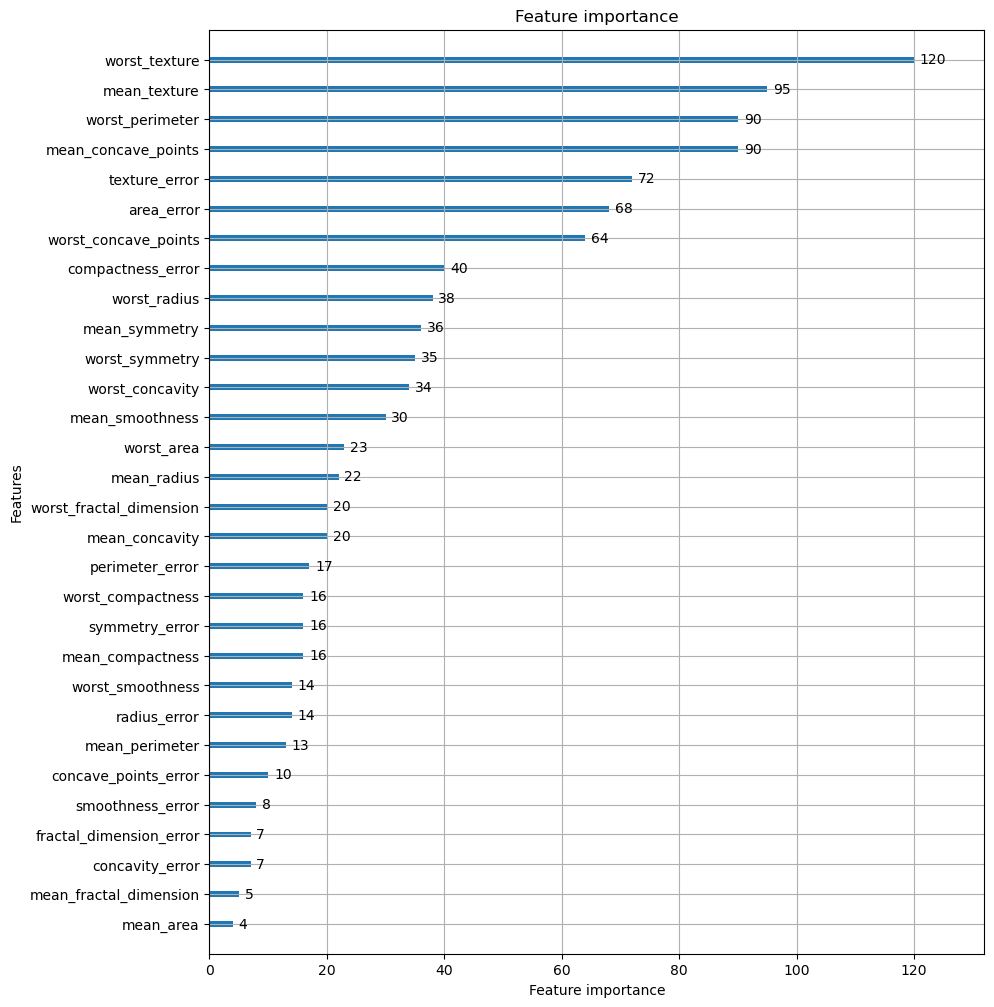

In [6]:
#plot_importance()를 이용하여 feature 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,12))
plot_importance(lgbm_wrapper, ax = ax)

## 베이지안 최적화 기반의 HyperOpt를 활용한 하이퍼 파라미터 튜닝
GridSearchCV의 경우 튜닝할 하이퍼 파라미터가 많을 경우 최적화 수행 시간이 오래 걸린다는 단점이 있음  
때문에 XGBoost나 LightGBM의 하이퍼 파라미터 튜닝 시에는 GridSearch방식보다 다른 방식을 적용함  
대표적으로 베이지안 최적화 기법

### 베이지안 최적화
베이지안 최적화는 목적 함수 식을 제대로 알 수 없는 블랙박스 형태의 함수에서 최대 또는 최소 함수 반환 값을 만드는 최적 입력값을 가능한 적은 시도를 통해 빠르고 효과적으로 찾아주는 방식  
새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적 함수 모델을 만든다

대체 모델: 획득 함수로부터 최적 함수를 예측할 수 있는 입력값을 추천 받은 뒤 이를 기반으로 최적 함수 모델 개선  
획득 함수: 개선된 대체 모델을 기반으로 최적 입력값을 계산  
베이지안 최적화를 하이퍼 파라미터 튜닝에 사용할 때 입력값은 하이퍼 파라미터  
대체 모델은 획득 함수가 계산한 하이퍼 파라미터를 입력받으면서 점차적으로 개선되며 개선된 대체 모델을 기반으로 획득함수는 더 정확한 하이퍼 파라미터를 계산

## HyperOpt 사용하기
HyperOpt 활용하는 주요 로직  
1. 입력 변수명과 입력값의 검색 공간 설정
2. 목적함수의 설정
3. 목적 함수의 반환 최솟값을 가지는 최적 입력값을 유추  
다른 패키지와 달리 목적함수 반환값의 최댓값이 아닌 최솟값을 가지는 최적 입력값을 유추

입력 변수명과 입력값 검색 공간: 파이썬 딕셔너리 형태로 설정  
입력변수명:입력변수의 검색공간

In [17]:
from hyperopt import hp
# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력 변수 y 설정
search_space = {'x':hp.quniform('x', -10, 10, 1), 'y':hp.quniform('y', -15, 15, 1)}

hp.quniform(label, low, high, q): label로 지정된 입력값 변수 공간을 low에서 high까지 q 간격을 가지고 설정  
<br>
hp.uniform(label, low, high): low에서 high까지 정규분포 형태의 검색 공간 설정  
<br>
hp.randint(label, upper): 0에서 upper까지 랜덤 정숫값으로 검색 공간 설정  
<br>
hp.loguniform(label, low, high): exp(uniform(low, high))값을 반환하며 반환 값의 log 변환된 값은 정규 분포 형태를 가지는 검색 공간 설정  
<br>
hp.choice(label, opntions): 검색 값이 문자열 또는 문자열과 숫자값이 섞여있을 경우 설정. options는 리스트나 튜플 형태로 제공되며  
hp.choice('tree_criterion',['gini','entropy'])와 같이 설정하면 tree_criterion의 값을 gini와 entropy로 설정하여 입력

목적 함수 생성  
변숫값과 검색공간을 가지는 딕셔너리를 인자로 받고, 특정 값을 반환하는 구조

In [18]:
from hyperopt import STATUS_OK

#목적함수를 생성. 변숫값과 변수 검색 공간을 가지는 딕셔너리를 인자로 받고 특정 값을 반환
def objective_func(search_space):
    x = search_space['x']
    y = search_space['y']
    retval = x**2 - 20*y
    return retval

목적함수의 반환값이 최소가 될 수 있는 최적의 입력값 찾기  
fmin(fn, space, algo, max_evals, trials)  
fn: objective_func와 같은 목적함수  
space: search_space와 같은 검색 공간 딕셔너리  
algo: 베이지안 최적화 적용 알고리즘  
max_evals: 최적 입력값을 찾기 위한 입력값 시도 횟수  
trials: 최적 입력값을 찾기 위해 시도한 입력값 및 해당 입력값의 목적함수 반환값 결과를 저장하는 데 사용  
rstate: 랜덤시드값

In [20]:
from hyperopt import fmin, tpe, Trials
#입력 결괏값을 저장한 Trials 객체값 생성
trial_val = Trials()

#목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄
best_01 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 5,
               trials = trial_val, rstate = np.random.default_rng(seed = 0))
print('best:', best_01)

100%|█████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 565.42trial/s, best loss: -224.0]
best: {'x': -4.0, 'y': 12.0}


In [23]:
#x는 0에, y는 15에 가까울수록 반환값이 최소로 근사
trial_val = Trials()
#max_eval를 20으로 설정
best_02 = fmin(fn = objective_func, space = search_space, algo = tpe.suggest, max_evals = 20,
               trials = trial_val, rstate = np.random.default_rng(seed = 0))
print('best:', best_02)

100%|███████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 608.09trial/s, best loss: -296.0]
best: {'x': 2.0, 'y': 15.0}


fmin()함수 수행 시 인자로 들어가는 Trials객체는 함수의 반복 수행 시마다 입력되는 변숫값들과 함수 반환값을 속성으로 가지고 있음  
Trials객체 주요 속성: results, vals  
result: 함수의 반복 수행 시마다 반환되는 반환값을 가짐  
vals: 함수의 반복 수행 시마다 입력되는 입력 변숫값  

result는 리스트 형태이며 리스트 내 개별 원소는 {'loss':함수반환값, 'status':반환상태값'}과 같은 딕셔너리

In [27]:
#fmin()에 인자로 들어가는 Trials 객체의 result속성에 파이썬 리스트로 목적 함수 반환값들이 저장됨
#리스트 내부의 개별 원소는 {'loss':함수반환값, 'status':반환상태값}와 같은 딕셔너리
print(trial_val.results)
#20회 반복수행했으므로 20개의 딕셔너리를 개별 원소로 가지는 리스트로 구성

[{'loss': -64.0, 'status': 'ok'}, {'loss': -184.0, 'status': 'ok'}, {'loss': 56.0, 'status': 'ok'}, {'loss': -224.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': -296.0, 'status': 'ok'}, {'loss': -40.0, 'status': 'ok'}, {'loss': 281.0, 'status': 'ok'}, {'loss': 64.0, 'status': 'ok'}, {'loss': 100.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': -39.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': -164.0, 'status': 'ok'}, {'loss': 21.0, 'status': 'ok'}, {'loss': -56.0, 'status': 'ok'}, {'loss': 284.0, 'status': 'ok'}, {'loss': 176.0, 'status': 'ok'}, {'loss': -171.0, 'status': 'ok'}, {'loss': 0.0, 'status': 'ok'}]


vals속성은 딕셔너리 형태  
fmin()함수 수행 시마다 입력되는 입력 변숫값들을 {'입력변수명':개별 수행시마다 입력된 값의 리스트}와 같은 형태로 가지고 있음

In [29]:
# Trials객체의 vals속성에 {'입력변수명':개별수행시마다 입력된 값 리스트} 형태로 저장
print(trial_val.vals)
# x와 y의 value는 20회 반복 수행마다 사용되는 입력값들을 리스트 형태로 저장

{'x': [-6.0, -4.0, 4.0, -4.0, 9.0, 2.0, 10.0, -9.0, -8.0, -0.0, -0.0, 1.0, 9.0, 6.0, 9.0, 2.0, -2.0, -4.0, 7.0, -0.0], 'y': [5.0, 10.0, -2.0, 12.0, 1.0, 15.0, 7.0, -10.0, 0.0, -5.0, -3.0, 2.0, 4.0, 10.0, 3.0, 3.0, -14.0, -8.0, 11.0, -0.0]}


In [30]:
#이를 데이터프레임으로 만들어서 확인
#입력변수x값은 x칼럼, vals속성의 x 키값을 칼럼값으로
#입력변수y값은 y칼럼, vals속성의 y 키값을 칼럼값으로
#함수반환값은 loss칼럼, results속성의 loss 키값에 해당하는 밸류를 추출하여 칼럼값으로 생성
import pandas as pd
# results에서 loss 키 값에 해당하는 밸류들을 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

#DataFrame으로 생성
result_df = pd.DataFrame({'x':trial_val.vals['x'],
                          'y':trial_val.vals['y'],
                          'losses':losses})
result_df

,x,y,losses
0,-6.0,5.0,-64.0
1,-4.0,10.0,-184.0
2,4.0,-2.0,56.0
3,-4.0,12.0,-224.0
4,9.0,1.0,61.0
5,2.0,15.0,-296.0
6,10.0,7.0,-40.0
7,-9.0,-10.0,281.0
8,-8.0,0.0,64.0
9,-0.0,-5.0,100.0


## HyperOpt를 이용한 XGBoost 하이퍼 파리미터 최적화
앞 예제와 크게 다르지 않으나 특정 하이퍼 파라미터는 정숫값만 입력을 받는데 HyperOpt는 입력값과 반환값이 모두 실수형이므로 형변환 필요  
HyperOpt의 목적 함수는 최솟값을 반환할 수 있도록 최적화해야하기 때문에 성능값이 클수록 좋은 성능 지표일 경우 -1을 곱해줘야 함

In [31]:
#전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size= 0.2, random_state = 156)

#앞에서 추출한 학습 데이터를 다시 학습용, 검증용으로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size= 0.1, random_state = 156)

In [35]:
from hyperopt import hp

#max_depth는 5에서 20까지 1간격, min_child_weight는 1에서 2까지 1간격으로
#colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2사이 정규분포된 값으로 검색
xgb_search_space = {'max_depth':hp.quniform('max_depth',5,20,1),
                    'min_child_weight':hp.quniform('min_child_weight',1,2,1),
                    'learning_rate':hp.uniform('learning_rate',0.01,0.2),
                    'colsample_bytree':hp.uniform('colsample_bytree',0.5,1)}

주의사항  
1. 검색 공간에서 목적 함수로 입력되는 모든 인자들은 실수형 값이므로 이를 XGBClassifier 하이퍼 파라미터 값으로 설정할 때는 정수형으로 형변환 해야함
2. HyperOpt의 목적 함수는 최솟값을 반환할 수 있도록 최적화해야하기 때문에 정확도와 같이 값이 클수록 좋은 성능 지표일 경우 -1을 곱한 뒤 봔환하여 더 큰 성능 지표가 더 작은 반환값이 되도록 설정

In [50]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

#fmin()에 입력된 search_space값으로 입력된 모든 값은 실수형임
#XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함
#정확도는 높을수록 더 좋은 수치이므로 -1을 곱해서 큰 정확도 값일수록 최소가 되도록 반환
def objective_func(search_space):
    #수행 시간 절약을 위해 nestimators는 100으로 축소
    xgb_clf = XGBClassifier(n_estimators = 100, max_depth = int(search_space['max_depth']),
                            min_child_weight = int(search_space['min_child_weight']),
                            learning_rate = search_space['learning_rate'],
                            colsample_bytree = search_space['colsample_bytree'],
                            eval_metric = 'logloss')
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring = 'accuracy', cv = 3)

    #accuracy는 cv=3 개수만큼 roc-auc결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함
    return { 'loss':-1*np.mean(accuracy), 'status':STATUS_OK }

In [52]:
#fmin()을 이용해 최적 하이퍼파라미터 도출
from hyperopt import fmin, tpe, Trials

trial_val = Trials()

best = fmin(fn = objective_func,
            space = xgb_search_space,
            algo = tpe.suggest,
            max_evals = 50, #최대 반복 횟수 지정
            trials = trial_val, rstate = np.random.default_rng(seed = 9))
print('best:', best)

#정수형 하이퍼파라미터인 max_depth, min_child_weight가 실수형 값으로 도출되었음에 유의

100%|███████████████████████████████████████████████| 50/50 [00:26<00:00,  1.90trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [53]:
#fmin()으로 추출된 하이퍼 파라미터를 직접 XGBClassifier에 인자로 입력하기 전에 정수형 하이퍼 파라미터는 정수형으로, 실수형 하이퍼 파라미터는 소수점 5자리까지만 변환 수 확인
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(round(best['colsample_bytree'], 5), round(best['learning_rate'],5),
                                                                                            int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.54241, learning_rate:0.12601, max_depth:17, min_child_weight:2


In [59]:
#도출된 최적 하이퍼 파라미터를 이용해 재학습 한 후 성능 평가 결과 확인
#XGBoost의 조기중단을 검증 데이터 세트로 활용, n_estimators는 400으로 증가
xgb_wrapper = XGBClassifier(n_estimators = 400,
                            learning_rate = round(best['learning_rate'], 5),
                            max_depth = int(best['max_depth']),
                            min_child_weight = int(best['min_child_weight']),
                            colsample_bytee = round(best['colsample_bytree'], 5))
evals = [ (X_tr, y_tr), (X_val, y_val) ]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 50, eval_metric = 'logloss',
                eval_set = evals, verbose = True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[15:10:42] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "colsample_bytee" } are not used.

[0]	validation_0-logloss:0.59003	validation_1-logloss:0.62146
[1]	validation_0-logloss:0.50919	validation_1-logloss:0.56750
[2]	validation_0-logloss:0.44256	validation_1-logloss:0.51487
[3]	validation_0-logloss:0.38849	validation_1-logloss:0.48449
[4]	validation_0-logloss:0.34293	validation_1-logloss:0.44620
[5]	validation_0-logloss:0.30368	validation_1-logloss:0.41606
[6]	validation_0-logloss:0.27108	validation_1-logloss:0.38899
[7]	validation_0-logloss:0.24259	validation_1-logloss:0.36614
[8]	validation_0-logloss:0.21930	validation_1-logloss:0.35055
[9]	validation_0-logloss:0.19740	validation_1-logloss:0.33662
[10]	validation_0-logloss:0.17946	validation_1-logloss:0.32383
[11]	validation_0-logloss:0.16281	validation_1-logloss:0.31202
[12]	validation_0-logloss:0.14843	validation_1-logloss:0.30130
[13]	validation_0-logloss:0.13625	validati

C:\Users\motor\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\motor\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[60]	validation_0-logloss:0.02130	validation_1-logloss:0.27399
[61]	validation_0-logloss:0.02102	validation_1-logloss:0.27467
[62]	validation_0-logloss:0.02088	validation_1-logloss:0.27430
[63]	validation_0-logloss:0.02075	validation_1-logloss:0.27308
[64]	validation_0-logloss:0.02061	validation_1-logloss:0.27491
[65]	validation_0-logloss:0.02049	validation_1-logloss:0.27378
[66]	validation_0-logloss:0.02036	validation_1-logloss:0.27551
[67]	validation_0-logloss:0.02024	validation_1-logloss:0.27517
[68]	validation_0-logloss:0.01989	validation_1-logloss:0.27222
[69]	validation_0-logloss:0.01978	validation_1-logloss:0.27226
[70]	validation_0-logloss:0.01966	validation_1-logloss:0.27396
[71]	validation_0-logloss:0.01955	validation_1-logloss:0.27283
[72]	validation_0-logloss:0.01945	validation_1-logloss:0.27444
[73]	validation_0-logloss:0.01934	validation_1-logloss:0.27448
[74]	validation_0-logloss:0.01924	validation_1-logloss:0.27344
[75]	validation_0-logloss:0.01914	validation_1-logloss: